In [1]:
from hatchet import *
import json
from state import State
from preprocess import PreProcess
import numpy as np
import utils
import random
import os
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.nonparametric.api as smnp

In [2]:
# dirname = '/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow'
dirname = '/home/vidi/Work/llnl/CallFlow/.callflow'
dataset = 'calc-pi'

In [3]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format

# Read entire dataset

In [4]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [5]:
def write_gf(state, state_name, format_of_df, write_graph=True):
    print('writing file for {0} format'.format(format_of_df))

    if write_graph:
        # dump the entire_graph as literal
        graph_literal = state.graph.to_literal(graph=state.graph, dataframe=state.df)
        graph_filepath = dirname + '/' + state_name + '/' + format_of_df + '_graph.json'
        print('File path: {0}'.format(graph_filepath))
        with open(graph_filepath, 'w') as graphFile:
            json.dump(graph_literal, graphFile)

    # dump the filtered dataframe to csv.
    df_filepath = dirname + '/' + state_name + '/' + format_of_df + '_df.csv'
    state.df.to_csv(df_filepath)

In [6]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   
    group_df_filepath = dirname + '/' + name + '/group_df.csv'

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal_persist(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal_persist(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)
    
    state.group_df = pd.read_csv(group_df_filepath)

    return state

In [7]:
##############################################################################
# Copyright (c) 2018-2019, Lawrence Livermore National Security, LLC.
# Produced at the Lawrence Livermore National Laboratory.
#
# This file is part of Callflow.
# Created by Suraj Kesavan <kesavan1@llnl.gov>.
# LLNL-CODE-741008. All rights reserved.
#
# For details, see: https://github.com/LLNL/Callflow
# Please also read the LICENSE file for the MIT License notice.
##############################################################################

#!/usr/bin/env python3

import pandas as pd
import time 
import utils
from logger import log

class Filter:
    '''
    Filter the graphframe.
    Input: State object, parameter to filterBy (could be inclusive/exclusive, 
            filterPerc: user provided filter percentage (1-100))
    '''
    def __init__(self, state, filterBy, filterPerc):
        utils.debug('filter By:', filterBy)
        utils.debug('filter Perc:', filterPerc)
        self.state = state
        self.graph = state.entire_graph
        self.df = state.entire_df
        self.gf = state.entire_gf

        self.df.set_index(['node', 'rank'], drop=False, inplace=True)

        # self.df = pd.MultiIndex.from_frame(self.df, names=['node', 'rank'])
        self.gf.dataframe = self.df
        
        self.filterBy = filterBy
        self.filterPercInDecimals = int(filterPerc)/100
        # self.filterPercInDecimals = 0.001 
        
        self.fgf = self.run() 
        self.fgf = self.graft()

        # update df and graph after filtering.
        self.df = self.fgf.dataframe
        self.graph = self.fgf.graph

    def run(self):
        log.info('Filtering the graph.')
        t = time.time()
        if self.filterBy == "Inclusive":
            max_inclusive_time = utils.getMaxIncTime_from_gf(self.graph, self.df)
            filter_gf = self.gf.filter(lambda x: True if(x['time (inc)'] > self.filterPercInDecimals*max_inclusive_time) else False)
        elif filterBy == "Exclusive":
            max_exclusive_time = utils.getMaxExcTime_from_gf(self.graph, self.df)
            log.info('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))
            filter_gf = self.gf.filter(lambda x: True if (x['time'] >= self.filterPercInDecimals*max_exclusive_time) else False)
        else:
            log.warn("Not filtering.... Can take forever. Thou were warned")
            filter_gf = self.gf
        
        log.info('[Filter] Removed {0} rows. (time={1})'.format(self.gf.dataframe.shape[0] - filter_gf.dataframe.shape[0], time.time() - t))

        return filter_gf

    def graft(self):
        log.info("Squashing the graph.")
        t = time.time()
        fgf = self.fgf.squash()
        log.info("[Squash] {1} rows in dataframe (time={0})".format(time.time() - t, fgf.dataframe.shape[0]))
        return fgf

In [8]:
def ffilter(state, filterBy, filterPerc):
        filter_obj = Filter(state, filterBy, filterPerc)

        state.gf = filter_obj.gf
        state.df = filter_obj.df
        state.graph = filter_obj.graph

        return state

In [9]:
state = read_gf(dataset)

In [10]:
print(state.df)

                   node  rank   time (inc)       time  nid  rank.1  \
0        <program root>     0   999,238.00       0.00    2       0   
1        <program root>     1   999,390.00       0.00    2       1   
2        <program root>     2 1,000,306.00       0.00    2       2   
3        <program root>     3   999,308.00       0.00    2       3   
4                  main     0   999,238.00       0.00    4       0   
..                  ...   ...          ...        ...  ...     ...   
63  <unknown procedure>     3   173,876.00       0.00   54       3   
64     <unknown file>:0     0   197,718.00 197,718.00   55       0   
65     <unknown file>:0     1   244,939.00 244,939.00   55       1   
66     <unknown file>:0     2   221,846.00 221,846.00   55       2   
67     <unknown file>:0     3   173,876.00 173,876.00   55       3   

              file  line                     module                 name  \
0   <unknown file>     0        libmonitor.so.0.0.0       <program root>   
1   <un

# Half-calc-pi dataset

In [34]:
def setvalues(state):
    random = pd.Series(np.random.rand(state.df.shape[0]))
    print(random)
#     state.df['time (inc)'] = state.df['time (inc)']*random
    state.df['time'] = state.df['time']*random
    print(state.df['time'])
    subgraph_sum(state, ['time'], ['time (inc)'])
    print(state.df['time (inc)'])
#     state.entire_df['time (inc)'] = state.entire_df['time (inc)']*random
    state.entire_df['time'] = state.entire_df['time']*random
    
#     state.group_df['time (inc)'] = state.group_df['time (inc)']*random
    return state

In [60]:
def test(state):
    state.df['time'] = state.df['time']*0.5
    subgraph_sum(state, ['time'], ['time (inc)'])

test(state)

NameError: name 'columns' is not defined

In [59]:
def init_sum_columns(state, columns, out_columns):
    """Helper function for subtree_sum and subgraph_sum."""
    if out_columns is None:
        out_columns = columns
    else:
        # init out columns with input columns in case they are not there.
        for col, out in zip(columns, out_columns):
            state.df[out] = state.df[col]

    if len(columns) != len(out_columns):
        raise ValueError("columns out_columns must be the same length!")

    return out_columns

In [51]:
def traverse(graph, order="pre", attrs=None, visited=None):
    # share visited dict so that we visit each node at most once.
    if visited is None:
        visited = {}

    # iterate over roots in order
    for root in sorted(graph.roots):
        for value in node_traverse(root, order=order, visited=visited):
            yield value

In [50]:
def node_traverse(node, order="pre", attrs=None, visited=None):
    if visited is None:
        visited = {}

    key = node.callpath[-1]
    if key in visited:
        # count the number of times we reached
        visited[key] += 1
        return
    visited[key] = 1

    def value(node):
        return node #if attrs is None else node.frame.values(attrs)

    if order == "pre":
        yield value(node)

    for child in sorted(node.children):
        for item in node_traverse(child, order=order, attrs=attrs, visited=visited):
            yield item

    if order == "post":
        yield value(self)

In [36]:
def is_tree(state):
    """True if this graph is a tree, false otherwise."""
    if len(state.graph.roots) > 1:
        return False

    visited = {}
    list(traverse(state.graph, visited=visited))
    return all(v == 1 for v in visited.values())

In [58]:
def subgraph_sum(state, in_columns, out_columns=None, function=np.sum):
    if is_tree(state):
        subtree_sum(columns, out_columns, function)
        return

    out_columns = init_sum_columns(state, columns, out_columns)
    for node in traverse(state.graph):
        subgraph_nodes = list(traverse_node(node))
        state.df.loc[node, out_columns] = list(function(state.df.loc[subgraph_nodes, columns]))

In [33]:
def create_dot_callflow_folder(dataset):
            dataset_dir = dirname + '/' + dataset
            if not os.path.exists(dataset_dir):
                utils.debug('Creating .callflow directory for dataset : {0}'.format(dataset))
                os.makedirs(dataset_dir)
    
            files = ["entire_df.csv", "filter_df.csv", "entire_graph.json", "filter_graph.json", "group_df.csv"]
            for f in files:
                if not os.path.exists(dataset_dir + '/' + f):
                    open(os.path.join(dataset_dir, f), 'w').close()

In [26]:
def create_n_runs(incoming_dataset, n, filterBy, filterPerc):
    states = {}
    for i in range(0, n):
        print("Reading dataset: ", incoming_dataset)
        state = read_gf(incoming_dataset)
        dataset = incoming_dataset + '-random-' + str(i)
        create_dot_callflow_folder(dataset)
        state = setvalues(state)
        states[dataset] = state
        write_gf(state, dataset, 'entire')
        print("Writing to entire dataset: ", dataset)
        state = ffilter(state, filterBy, filterPerc) 
        print("Writing to filter dataset: ", dataset)
        write_gf(state, dataset, 'filter')
        df_filepath = dirname + '/' + dataset + '/' +'group_df.csv'
        state.group_df.to_csv(df_filepath)
    return states

In [27]:
states = create_n_runs('calc-pi', 1, 'Inclusive', 1)

Reading dataset:  calc-pi
0    0.08
1    0.58
2    0.43
3    0.40
4    0.09
     ... 
63   0.32
64   0.47
65   0.21
66   0.80
67   0.46
Length: 68, dtype: float64
0          0.00
1          0.00
2          0.00
3          0.00
4          0.00
        ...    
63         0.00
64    93,252.70
65    50,476.04
66   178,197.75
67    79,815.09
Name: time, Length: 68, dtype: float64


TypeError: traverse() missing 1 required positional argument: 'root'

In [31]:
def iqr(a):
    """Calculate the IQR for an array of numbers."""
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    return q3 - q1

In [35]:
 def kde(data, gridsize=512, fft=True, kernel='gau', bw='scott', cut=3, clip=(-np.inf, np.inf)):
        print("Data is ", data)
        
        # assign binwidth using scott's factor
        if bw == 'scott':
            bw = stats.gaussian_kde(data).scotts_factor() * data.std(ddof=1)
        print("biwidth is: ", bw)    
        
        kde = smnp.KDEUnivariate(data)
        kde_gau = stats.gaussian_kde(data, bw_method=bw)
        
        # create the grid to fit the estimation.
        # clip = (0, data.max())
        # print(clip)
        support_min = max(data.min() - bw * cut, clip[0])
        support_max = min(data.max() + bw * cut, clip[1])
#         support_min = max(0, clip[0])
#         support_max = min(data.max(), clip[1])
        grid = np.linspace(support_min, support_max, gridsize)
        clip = (support_min, support_max)
        print("Grid is: ", grid.shape)
        
        kde.fit("gau", bw, fft, gridsize=gridsize, cut=cut, clip=clip)
        y = kde.density
        print("Y is: ", y.shape)
        x = grid
                
        return grid, y

In [36]:
def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))

In [33]:
def calculate_distributions(states):
    results = {}
    modules = states['calc-pi-random-0'].df['module'].unique()
    num_of_bins = {}
    kde_grid = {}
    for module in modules:
        dist = {}
        mean_dist = {}
        for idx, state in enumerate(states):
            time_inc_df = states[state].df.loc[states[state].df['module'] == module]['time (inc)'].tolist()
            dist[state] = time_inc_df
            mean_dist[state] = np.mean(time_inc_df)
        np_mean_dist = np.array(tuple(mean_dist.values()))
        num_of_bins[module] = _freedman_diaconis_bins(np_mean_dist)
        kde_grid[module] = kde(np_mean_dist)
        print(kde_grid[module][0])
        series = pd.DataFrame({ 'x':kde_grid[module][0], 'y': kde_grid[module][1] })
        print(series)
        ax = sns.lineplot(x="x", y="y", data=series)
        print(kde_grid)
        results[module] = {
            "dist": dist,
            "mean_dist": mean_dist, 
            "bins": num_of_bins,
            "kde_x": kde_grid[module][0],
            "kde_y": kde_grid[module][1]
        }
    return results

{'calc-pi-random-0': <state.State object at 0x7f3ea84d9f60>, 'calc-pi-random-1': <state.State object at 0x7f3ea8a61b00>, 'calc-pi-random-2': <state.State object at 0x7f3ea859e978>, 'calc-pi-random-3': <state.State object at 0x7f3ec0a214a8>, 'calc-pi-random-4': <state.State object at 0x7f3ea841b128>, 'calc-pi-random-5': <state.State object at 0x7f3ea842c940>, 'calc-pi-random-6': <state.State object at 0x7f3ea842ceb8>, 'calc-pi-random-7': <state.State object at 0x7f3ea8372a58>, 'calc-pi-random-8': <state.State object at 0x7f3ea84919b0>, 'calc-pi-random-9': <state.State object at 0x7f3ea841e358>}
Data is  [543980.11512663 469512.19909437 327393.90506096 660260.70409267
 459124.29065803 391246.10716981 426894.51778137 457131.0052616
 428375.82512951 408746.41060913]
biwidth is:  57296.514845899204
Grid is:  (512,)
Y is:  (512,)
[155504.36052327 156828.52077396 158152.68102466 159476.84127536
 160801.00152606 162125.16177676 163449.32202746 164773.48227816
 166097.64252886 167421.80277955 1

{'libmonitor.so.0.0.0': (array([155504.36052327, 156828.52077396, 158152.68102466, 159476.84127536,
       160801.00152606, 162125.16177676, 163449.32202746, 164773.48227816,
       166097.64252886, 167421.80277955, 168745.96303025, 170070.12328095,
       171394.28353165, 172718.44378235, 174042.60403305, 175366.76428375,
       176690.92453445, 178015.08478515, 179339.24503584, 180663.40528654,
       181987.56553724, 183311.72578794, 184635.88603864, 185960.04628934,
       187284.20654004, 188608.36679074, 189932.52704143, 191256.68729213,
       192580.84754283, 193905.00779353, 195229.16804423, 196553.32829493,
       197877.48854563, 199201.64879633, 200525.80904703, 201849.96929772,
       203174.12954842, 204498.28979912, 205822.45004982, 207146.61030052,
       208470.77055122, 209794.93080192, 211119.09105262, 212443.25130331,
       213767.41155401, 215091.57180471, 216415.73205541, 217739.89230611,
       219064.05255681, 220388.21280751, 221712.37305821, 223036.53330891,


{'libmonitor.so.0.0.0': {'dist': {'calc-pi-random-0': [115442.73790535808, 876785.0930246924, 679517.7725602627, 949268.8412621478, 634894.337311382, 267485.6396055712, 543685.1538234846, 284761.34552016895], 'calc-pi-random-1': [59320.08549288394, 47201.031498646946, 175211.9936686811, 299133.7635440306, 838208.1025583667, 972624.3984033994, 963219.8006009712, 401178.4169879871], 'calc-pi-random-2': [211327.6556210638, 427718.30024014274, 386492.69310977275, 408004.8693968412, 8885.204930990729, 363302.93864836113, 147564.8268096911, 665854.751730839], 'calc-pi-random-3': [728559.430851827, 453523.9302164141, 859142.179534881, 836556.142381082, 892773.5002310512, 583548.7765040521, 716749.3461736761, 211232.32684835224], 'calc-pi-random-4': [882059.38354881, 764977.382041689, 209059.49550934983, 469220.3483196822, 188591.05309428248, 369424.4423909128, 159188.2113112951, 630474.0090482398], 'calc-pi-random-5': [180052.93038375865, 712103.4932402042, 692968.7499174464, 231051.562587947

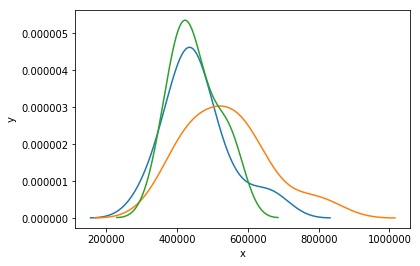

In [37]:
print(states)
results = calculate_distributions(states)
print(results)

{'dist': {'calc-pi-random-0': [115442.73790535808, 876785.0930246924, 679517.7725602627, 949268.8412621478, 634894.337311382, 267485.6396055712, 543685.1538234846, 284761.34552016895], 'calc-pi-random-1': [59320.08549288394, 47201.031498646946, 175211.9936686811, 299133.7635440306, 838208.1025583667, 972624.3984033994, 963219.8006009712, 401178.4169879871], 'calc-pi-random-2': [211327.6556210638, 427718.30024014274, 386492.69310977275, 408004.8693968412, 8885.204930990729, 363302.93864836113, 147564.8268096911, 665854.751730839], 'calc-pi-random-3': [728559.430851827, 453523.9302164141, 859142.179534881, 836556.142381082, 892773.5002310512, 583548.7765040521, 716749.3461736761, 211232.32684835224], 'calc-pi-random-4': [882059.38354881, 764977.382041689, 209059.49550934983, 469220.3483196822, 188591.05309428248, 369424.4423909128, 159188.2113112951, 630474.0090482398], 'calc-pi-random-5': [180052.93038375865, 712103.4932402042, 692968.7499174464, 231051.5625879474, 32201.04653889534, 53

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

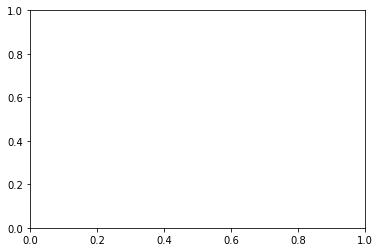

In [38]:
result = results['libmonitor.so.0.0.0']
print(result)
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

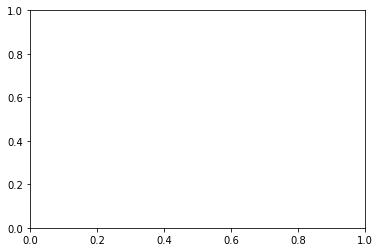

In [39]:
result = results['cpi']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

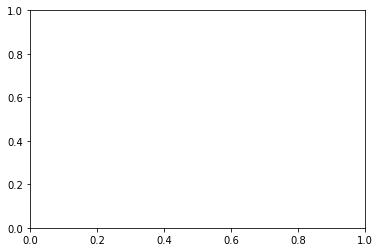

In [40]:
result = results['libmpi.so.12.0.5']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [41]:
dataset = 'calc-pi-random-0'
state = read_gf(dataset)
print(state.df)

                      node  rank                  node.1  rank.1  time (inc)  \
0           <program root>     0          <program root>       0  115,442.74   
1           <program root>     1          <program root>       1  876,785.09   
2           <program root>     2          <program root>       2  679,517.77   
3           <program root>     3          <program root>       3  949,268.84   
4                     main     0                    main       0   41,068.64   
..                     ...   ...                     ...     ...         ...   
19       294:MPID_Finalize     3       294:MPID_Finalize       3   52,366.50   
20  162:MPIDI_CH3_Finalize     0  162:MPIDI_CH3_Finalize       0  244,064.85   
21  162:MPIDI_CH3_Finalize     1  162:MPIDI_CH3_Finalize       1  906,424.80   
22  162:MPIDI_CH3_Finalize     2  162:MPIDI_CH3_Finalize       2  606,802.19   
23  162:MPIDI_CH3_Finalize     3  162:MPIDI_CH3_Finalize       3  553,007.67   

    time  nid  rank.1.1                

AxesSubplot(0.125,0.125;0.775x0.755)


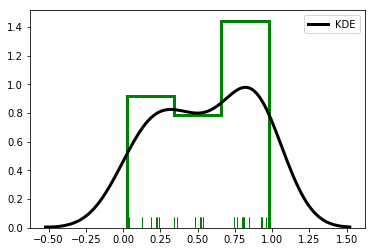

In [42]:
random = np.random.rand(state.df.shape[0])
ax = sns.distplot(random, hist=False, rug=True);
print(ax)

ax = sns.distplot(random, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [43]:
def sshist(x, N=range(2, 501), SN=30):
    """
    Returns the optimal number of bins in a histogram used for density
    estimation.
    Optimization principle is to minimize expected L2 loss function between
    the histogram and an unknown underlying density function.
    An assumption made is merely that samples are drawn from the density
    independently each other.
    The optimal binwidth D* is obtained as a minimizer of the formula,
    (2K-V) / D^2,
    where K and V are mean and variance of sample counts across bins with width
    D. Optimal number of bins is given as (max(x) - min(x)) / D.
    Parameters
    ----------
    x : array_like
        One-dimensional data to fit histogram to.
    N : array_like, optional
        Array containing number of histogram bins to evaluate for fit.
        Default value = 500.
    SN : double, optional
        Scalar natural number defining number of bins for shift-averaging.
    Returns
    -------
    optN : int
        Optimal number of bins to represent the data in X
    N : double
        Maximum number of bins to be evaluated. Default value = 500.
    C : array_like
        Cost function C[i] of evaluating histogram fit with N[i] bins
    See Also
    --------
    sskernel, ssvkernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "A method for selecting the bin size
           of a time histogram," in  Neural Computation 19(6), 1503-1527, 2007
           http://dx.doi.org/10.1162/neco.2007.19.6.1503
    """

    # determine range of input 'x'
    x_min = np.min(x)
    x_max = np.max(x)

    # get smallest difference 'dx' between all pairwise samples
    buf = np.abs(np.diff(np.sort(x)))
    dx = min(buf[buf > 0])

    # setup bins to evaluate
    N_MIN = 2
    N_MAX = min(np.floor((x_max - x_min) / (2*dx)), max(N))
    N_MAX = N_MAX.astype(int)  
    N = range(N_MIN, N_MAX+1)
    D = (x_max - x_min) / N

    # compute cost function over each possible number of bins
    Cs = np.zeros((len(N), SN))
    for i, n in enumerate(N):  # loop over number of bins
        shift = np.linspace(0, D[i], SN)
        for p, sh in enumerate(shift):  # loop over shift window positions

            # define bin edges
            edges = np.linspace(x_min + sh - D[i]/2,
                                x_max + sh - D[i]/2, N[i]+1)

            # count number of events in these bins
            ki = np.histogram(x, edges)

            # get mean and variance of events
            k = ki[0].mean()
            v = np.sum((ki[0] - k)**2) / N[i]

            Cs[i, p] = (2*k - v) / D[i]**2

    # average over shift window
    C = Cs.mean(axis=1)
    
    # get bin count that minimizes cost C
    idx = np.argmin(C)
    optN = N[idx]
    optD = D[idx]
    edges = np.linspace(x_min, x_max, optN)

    return optN, optD, edges, C, N

In [44]:
data = [999560.5, 522136.93900397, 505126.27075341, 714996.49335358, 565991.23472955]
sshist(data)

(2,
 247217.114623295,
 array([505126.27075341, 999560.5       ]),
 array([3.74968151e-11, 5.20864850e-11, 5.97222000e-11, 7.36301096e-11,
        8.71289631e-11, 1.07445419e-10, 1.31852437e-10, 1.48078332e-10,
        1.68394788e-10, 1.87620428e-10, 2.04937139e-10, 2.19526808e-10,
        2.34389182e-10]),
 range(2, 15))

In [46]:
def ssvkernel(x, tin=None, M=80, nbs=1e2, WinFunc='Boxcar'):
    """
    Generates a locally adaptive kernel-density estimate for one-dimensional
    data.
    The user provides a one-dimensional vector of samples drawn from some
    underlying unknown distribution, and optionally the values where they want
    to estimate the probability density of that distribution. The algorithm
    solves an optimization problem to identify variable bandwidths across the
    domain where the data is provided.
    The optimization is based on a principle of minimizing expected L2 loss
    function between the kernel estimate and an unknown underlying density
    function. An assumption is merely that samples are drawn from the density
    independently of each other.
    The locally adaptive bandwidth is obtained by iteratively computing optimal
    fixed-size bandwidths wihtihn local intervals. The optimal bandwidths are
    selected such that they are selected in the intervals that are gamma times
    larger than the optimal bandwidths themselves. The paramter gamma is
    optimized by minimizing the L2 risk estimate.
    Parameters
    ----------
    x : array_like
        The one-dimensional samples drawn from the underlying density
    tin : array_like, optional
        The values where the density estimate is to be evaluated in generating
        the output 'y'. Default value = None.
    M : int, optional
        The number of window sizes to evaluate. Default value = 80.
    nbs : int, optional
        The number of bootstrap samples to use in estimating the [0.05, 0.95]
        confidence interval of the output 'y'.
    WinFunc : string, optional
        The type of window function to use in estimating local bandwidth.
        Choose from one of 'Boxcar', 'Laplace', 'Cauchy' and 'Gauss'. Default
        value = 'Gauss'.
    Returns
    -------
    y : array_like
        The estimated density, evaluated at points t / tin.
    t : array_like
        The points where the density estimate 'y' is evaluated.
    optw : array_like
        The optimal local kernel bandwidths at 't'.
    gs : array_like
        The stiffness constants of the variables bandwidths evaluated.
    C : array_like
        Cost functions associated with stiffness constraints.
    confb95 : array_like
        The 5% and 95% confidence interval of the kernel density estimate 'y'.
        Has dimensions 2 x len(y). confb95[0,:] corresponds to the 5% interval,
        and confb95[1,:] corresponds to the 95% interval.
    yb : array_like
        The bootstrap samples used in estimating confb95. Each row corresponds
        to one bootstrap sample.
    See Also
    --------
    sshist, sskernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """

    # set argument 't' if not provided
    if tin is None:
        T = np.max(x) - np.min(x)
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        tin = np.linspace(np.min(x), np.max(x), min(np.ceil(T / dt_samp), 1e3))
        t = tin
        print(min(tin), max(tin),(x >= min(tin)) & (x <= max(tin)) )
#         x_ab = x[bool(x >= min(tin)) & (x <= max(tin))]
        x_ab = x
    else:
        T = np.max(x) - np.min(x)
        x_ab = x[(x >= min(tin)) & (x <= max(tin))]
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        if dt_samp > min(np.diff(tin)):
            t = np.linspace(min(tin), max(tin), min(np.ceil(T / dt_samp), 1e3))
        else:
            t = tin

    # calculate delta t
    dt = min(np.diff(t))

    # create the finest histogram
    thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
    y_hist = np.histogram(x_ab, thist-dt/2)[0] / dt
    L = y_hist.size
    N = sum(y_hist * dt).astype(np.float)

    # initialize window sizes
    W = logexp(np.linspace(ilogexp(5 * dt), ilogexp(T), M))

    # compute local cost functions
    c = np.zeros((M, L))
    for j in range(M):
        w = W[j]
        yh = fftkernel(y_hist, w / dt)
        c[j, :] = yh**2 - 2 * yh * y_hist + 2 / (2 * np.pi)**0.5 / w * y_hist

    # initialize optimal ws
    optws = np.zeros((M, L))
    for i in range(M):
        Win = W[i]
        C_local = np.zeros((M, L))
        for j in range(M):
            C_local[j, :] = fftkernelWin(c[j, :], Win / dt, WinFunc)
        n = np.argmin(C_local, axis=0)
        optws[i, :] = W[n]

    # golden section search for stiffness parameter of variable bandwidths
    k = 0
    gs = np.zeros((30, 1))
    C = np.zeros((30, 1))
    tol = 1e-5
    a = 1e-12
    b = 1
    phi = (5**0.5 + 1) / 2
    c1 = (phi - 1) * a + (2 - phi) * b
    c2 = (2 - phi) * a + (phi - 1) * b
    f1 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c1)[0]
    f2 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c2)[0]
    while (np.abs(b-a) > tol * (abs(c1) + abs(c2))) & (k < 30):
        if f1 < f2:
            b = c2
            c2 = c1
            c1 = (phi - 1) * a + (2 - phi) * b
            f2 = f1
            f1, yv1, optwp1 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c1)
            yopt = yv1 / np.sum(yv1 * dt)
            optw = optwp1
        else:
            a = c1
            c1 = c2
            c2 = (2 - phi) * a + (phi - 1) * b
            f1 = f2
            f2, yv2, optwp2 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c2)
            yopt = yv2 / np.sum(yv2 * dt)
            optw = optwp2

        # capture estimates and increment iteration counter
        gs[k] = c1
        C[k] = f1
        k = k + 1

    # discard unused entries in gs, C
    gs = gs[0:k]
    C = C[0:k]

    # estimate confidence intervals by bootstrapping
    nbs = np.asarray(int(nbs))
    print(nbs)
    yb = np.zeros((nbs, tin.size))
    print(yb)
    for idx in range(nbs):
        Nb = np.random.poisson(lam=N)
        idx = np.random.randint(0, N, Nb)
        xb = x_ab[idx]
        thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
        y_histb = np.histogram(xb, thist - dt / 2)[0]
        idx = y_histb.nonzero()
        y_histb_nz = y_histb[idx]
        t_nz = t[idx]
        yb_buf = np.zeros((L, ))
        for k in range(L):
            yb_buf[k] = np.sum(y_histb_nz * Gauss(t[k] - t_nz, optw[k])) / Nb
        yb_buf = yb_buf / np.sum(yb_buf * dt)
        yb[i, :] = np.interp(tin, t, yb_buf)
    ybsort = np.sort(yb, axis=0)
    y95b = ybsort[np.int(np.floor(0.05 * nbs)), :]
    y95u = ybsort[np.int(np.floor(0.95 * nbs)), :]
    confb95 = np.concatenate((y95b[np.newaxis], y95u[np.newaxis]), axis=0)

    # return outputs
    y = np.interp(tin, t, yopt)
    optw = np.interp(tin, t, optw)
    t = tin

    return y, t, optw, gs, C, confb95, yb


def CostFunction(y_hist, N, t, dt, optws, WIN, WinFunc, g):

    L = y_hist.size
    optwv = np.zeros((L, ))
    for k in range(L):
        gs = optws[:, k] / WIN
        if g > np.max(gs):
            optwv[k] = np.min(WIN)
        else:
            if g < min(gs):
                optwv[k] = np.max(WIN)
            else:
                idx = np.max(np.nonzero(gs >= g))
                optwv[k] = g * WIN[idx]

    # Nadaraya-Watson kernel regression
    optwp = np.zeros((L, ))
    for k in range(L):
        if WinFunc == 'Boxcar':
            Z = Boxcar(t[k]-t, optwv / g)
        elif WinFunc == 'Laplace':
            Z = Laplace(t[k]-t, optwv / g)
        elif WinFunc == 'Cauchy':
            Z = Cauchy(t[k]-t, optwv / g)
        else:  # WinFunc == 'Gauss'
            Z = Gauss(t[k]-t, optwv / g)
        optwp[k] = np.sum(optwv * Z) / np.sum(Z)

    # speed-optimized baloon estimator
    idx = y_hist.nonzero()
    y_hist_nz = y_hist[idx]
    t_nz = t[idx]
    yv = np.zeros((L, ))
    for k in range(L):
        yv[k] = np.sum(y_hist_nz * dt * Gauss(t[k]-t_nz, optwp[k]))
    yv = yv * N / np.sum(yv * dt)

    # cost function of estimated kernel
    cg = yv**2 - 2 * yv * y_hist + 2 / (2 * np.pi)**0.5 / optwp * y_hist
    Cg = np.sum(cg * dt)

    return Cg, yv, optwp


def fftkernel(x, w):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))

    # evaluate kernel
    K = np.exp(-0.5 * (w * 2 * np.pi * f) ** 2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def fftkernelWin(x, w, WinFunc):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))
    t = 2 * np.pi * f

    # determine window function - evaluate kernel
    if WinFunc == 'Boxcar':
        a = 12**0.5 * w
        K = 2 * np.sin(a * t / 2) / (a * t)
        K[0] = 1
    elif WinFunc == 'Laplace':
        K = 1 / (1 + (w * 2 * np.pi * f)**2 / 2)
    elif WinFunc == 'Cauchy':
        K = np.exp(-w * np.abs(2 * np.pi * f))
    else:  # WinFunc == 'Gauss'
        K = np.exp(-0.5 * (w * 2 * np.pi * f)**2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def Gauss(x, w):
    y = 1 / (2 * np.pi)**2 / w * np.exp(-x**2 / 2 / w**2)
    return y


def Laplace(x, w):
    y = 1 / 2**0.5 / w * np.exp(-(2**0.5) / w / np.abs(x))
    return y


def Cauchy(x, w):
    y = 1 / (np.pi * w * (1 + (x / w)**2))
    return y


def Boxcar(x, w):
    a = 12**0.5 * w
    y = 1 / a
    y[np.abs(x) > a / 2] = 0
    return y


def logexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(1+np.exp(x[x < 1e2]))
    y[x >= 1e2] = x[x >= 1e2]
    return y


def ilogexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(np.exp(x[x < 1e2]) - 1)
    y[x >= 1e2] = x[x >= 1e2]
    return y

In [47]:
ssvkernel(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:238: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:260: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in true_divide


505126.27075341 999560.5 [ True  True  True  True  True]
100
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: only integer scalar arrays can be converted to a scalar index